# Classifier Comparison Visualization

This notebook visualizes the comparison of 11 oversampling methods across 29 datasets,
4 classifiers (RandomForest, DecisionTree, kNN, MLP), and 4 metrics (AUROC, G-mean, MCC, F1-score).

**Methods compared:**
- Original (no oversampling)
- ROS (Random OverSampling)
- SMOTE
- bSMOTE (Borderline-SMOTE)
- ADASYN
- MWMOTE
- CTGAN
- GAMO
- MGVAE
- MMD (beta=0.0)
- MMD+T (beta=0.01)


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path

# ============================================================================
# Publication-Quality Style Settings (NeurIPS/ICML/ICLR compatible)
# ============================================================================

# Use LaTeX-like fonts for publication quality
plt.rcParams.update({
    # Font settings - use serif fonts similar to LaTeX
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif', 'Computer Modern Roman'],
    'mathtext.fontset': 'cm',  # Computer Modern for math
    
    # Font sizes (adjusted for ~3.25in column width figures)
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.title_fontsize': 9,
    
    # Figure settings
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.02,
    
    # Axes settings
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    
    # Tick settings
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    
    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '0.8',
    'legend.fancybox': False,
    
    # Line settings
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
})

# Column width for NeurIPS/ICML papers (in inches)
COLUMN_WIDTH = 3.25
TEXT_WIDTH = 6.75
GOLDEN_RATIO = 1.618

print("Publication-quality style settings loaded.")


Publication-quality style settings loaded.


In [2]:
# Define paths
BASE_PATH = Path('../../results/ablations')
CLASSIFIERS_PATH = BASE_PATH / 'classifiers'
BETAS_PATH = BASE_PATH / 'betas'
REAL_EXAMPLES_PATH = BASE_PATH / 'real_examples'

# 29 datasets from the paper
DATASETS_29 = [
    'abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000',
    'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4',
    'oil', 'ozone_level', 'pima', 'scene', 'segment0',
    'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality',
    'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3_vs_7',
    'winequality-white-3-9_vs_5', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7',
    'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6'
]

# 4 classifiers
CLASSIFIERS = ['DecisionTree', 'RandomForest', 'kNN', 'MLP']

# 4 metrics
METRICS = ['AUROC', 'G-mean', 'MCC', 'F1-score']

# 11 methods to compare (in display order)
METHODS = ['Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN', 
           'GAMO', 'MGVAE', 'MMD', 'MMD+T']

print(f"Number of datasets: {len(DATASETS_29)}")
print(f"Classifiers: {CLASSIFIERS}")
print(f"Metrics: {METRICS}")
print(f"Methods: {METHODS}")


Number of datasets: 29
Classifiers: ['DecisionTree', 'RandomForest', 'kNN', 'MLP']
Metrics: ['AUROC', 'G-mean', 'MCC', 'F1-score']
Methods: ['Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN', 'GAMO', 'MGVAE', 'MMD', 'MMD+T']


In [3]:
def load_classifiers_data(dataset_name):
    """
    Load data from classifiers folder.
    Returns data for: Original, ROS, SMOTE, bSMOTE, ADASYN, MWMOTE, CTGAN
    """
    file_path = CLASSIFIERS_PATH / f"{dataset_name}_results.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    # Filter only relevant methods and classifiers
    methods_map = {
        'Original': 'Original',
        'ROS': 'ROS', 
        'SMOTE': 'SMOTE',
        'bSMOTE': 'bSMOTE',
        'ADASYN': 'ADASYN',
        'MWMOTE': 'MWMOTE',
        'CTGAN': 'CTGAN'
    }
    
    df = df[df['Method'].isin(methods_map.keys())]
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_mmd_only_data(dataset_name):
    """
    Load MMD data from betas folder (beta_0.0.csv).
    """
    file_path = BETAS_PATH / f"{dataset_name}_results_gaussian_beta_0.0.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df['Method'] = 'MMD'
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_mmd_triplet_data(dataset_name):
    """
    Load MMD+T data from betas folder (beta_0.01.csv).
    """
    file_path = BETAS_PATH / f"{dataset_name}_results_gaussian_beta_0.01.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df['Method'] = 'MMD+T'
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_gamo_mgvae_data(dataset_name):
    """
    Load GAMO and MGVAE data from real_examples folder (GAMO_MGVAE files).
    """
    # Search for GAMO_MGVAE files with any beta value
    pattern = str(REAL_EXAMPLES_PATH / f"{dataset_name}_results_GAMO_MGVAE_beta_*.csv")
    files = glob.glob(pattern)
    
    if not files:
        return None
    
    # Use the first matching file (they should have the same structure)
    df = pd.read_csv(files[0])
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df = df[df['Method'].isin(['GAMO', 'MGVAE'])]
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


# Test loading
test_df = load_classifiers_data('abalone9-18')
print(f"Classifiers data shape: {test_df.shape if test_df is not None else None}")
print(test_df.head() if test_df is not None else None)


Classifiers data shape: (112, 4)
      Method    Classifier Metric    Value
1   Original  DecisionTree  AUROC  0.66013
2   Original           kNN  AUROC  0.68049
3   Original           MLP  AUROC  0.58917
4   Original  RandomForest  AUROC  0.83723
10     SMOTE  DecisionTree  AUROC  0.67474


In [4]:
# Load all data
all_data = []
datasets_loaded = []

for dataset in DATASETS_29:
    # Load from classifiers folder
    clf_df = load_classifiers_data(dataset)
    if clf_df is not None:
        clf_df['Dataset'] = dataset
        all_data.append(clf_df)
    
    # Load MMD from betas
    mmd_only_df = load_mmd_only_data(dataset)
    if mmd_only_df is not None:
        mmd_only_df['Dataset'] = dataset
        all_data.append(mmd_only_df)
    
    # Load MMD+T from betas
    mmd_triplet_df = load_mmd_triplet_data(dataset)
    if mmd_triplet_df is not None:
        mmd_triplet_df['Dataset'] = dataset
        all_data.append(mmd_triplet_df)
    
    # Load GAMO and MGVAE from real_examples
    gamo_mgvae_df = load_gamo_mgvae_data(dataset)
    if gamo_mgvae_df is not None:
        gamo_mgvae_df['Dataset'] = dataset
        all_data.append(gamo_mgvae_df)
    
    if clf_df is not None:
        datasets_loaded.append(dataset)

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)
print(f"Total rows: {len(df_all)}")
print(f"Datasets loaded: {len(datasets_loaded)}")
print(f"\nDatasets: {datasets_loaded}")


Total rows: 5104
Datasets loaded: 29

Datasets: ['abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000', 'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4', 'oil', 'ozone_level', 'pima', 'scene', 'segment0', 'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality', 'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3_vs_7', 'winequality-white-3-9_vs_5', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7', 'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6']


In [5]:
# Check data availability
print("Data availability per method:")
method_counts = df_all.groupby('Method')['Dataset'].nunique()
for method in METHODS:
    count = method_counts.get(method, 0)
    print(f"  {method}: {count} datasets")

print(f"\nUnique methods in data: {df_all['Method'].unique()}")


Data availability per method:
  Original: 29 datasets
  ROS: 29 datasets
  SMOTE: 29 datasets
  bSMOTE: 29 datasets
  ADASYN: 29 datasets
  MWMOTE: 29 datasets
  CTGAN: 29 datasets
  GAMO: 29 datasets
  MGVAE: 29 datasets
  MMD: 29 datasets
  MMD+T: 29 datasets

Unique methods in data: ['Original' 'SMOTE' 'ADASYN' 'bSMOTE' 'ROS' 'MWMOTE' 'CTGAN' 'MMD' 'MMD+T'
 'GAMO' 'MGVAE']


In [6]:
# Calculate average metrics per method and classifier
def compute_avg_metrics(df, methods_to_include):
    """
    Compute average metrics for each method and classifier combination.
    """
    df_filtered = df[df['Method'].isin(methods_to_include)].copy()
    
    # Calculate mean across datasets
    avg_df = df_filtered.groupby(['Method', 'Classifier', 'Metric'])['Value'].mean().reset_index()
    avg_df = avg_df.rename(columns={'Value': 'Mean'})
    
    # Also calculate std
    std_df = df_filtered.groupby(['Method', 'Classifier', 'Metric'])['Value'].std().reset_index()
    std_df = std_df.rename(columns={'Value': 'Std'})
    
    # Merge
    result = avg_df.merge(std_df, on=['Method', 'Classifier', 'Metric'])
    
    return result

avg_metrics = compute_avg_metrics(df_all, METHODS)
print(f"Average metrics shape: {avg_metrics.shape}")
avg_metrics.head(20)


Average metrics shape: (176, 5)


,Method,Classifier,Metric,Mean,Std
0,ADASYN,DecisionTree,AUROC,0.759916,0.122117
1,ADASYN,DecisionTree,F1-score,0.390527,0.274520
2,ADASYN,DecisionTree,G-mean,0.667241,0.191511
3,ADASYN,DecisionTree,MCC,0.370602,0.271418
4,ADASYN,MLP,AUROC,0.849354,0.101411
5,ADASYN,MLP,F1-score,0.378168,0.224055
6,ADASYN,MLP,G-mean,0.709513,0.157398
7,ADASYN,MLP,MCC,0.367771,0.213128
8,ADASYN,RandomForest,AUROC,0.883615,0.097802
9,ADASYN,RandomForest,F1-score,0.428174,0.296110


In [17]:
# ============================================================================
# Color Palette and Method Configuration
# ============================================================================
# Design principle: MMD+T (Ours) should stand out visually with RED
# - Baselines: muted/neutral colors (gray/blue tones)
# - Deep learning baselines (CTGAN, GAMO, MGVAE): muted tones
# - Ours (MMD, MMD+T): BOLD RED tones for maximum emphasis ★

# Color scheme optimized for publication
METHOD_COLORS = {
    # Baselines - neutral/cool tones (muted, de-emphasized)
    'Original': '#bdbdbd',       # Light gray
    'ROS': '#969696',            # Medium gray
    'SMOTE': '#74a9cf',          # Light blue
    'bSMOTE': '#3690c0',         # Medium blue  
    'ADASYN': '#0570b0',         # Dark blue
    'MWMOTE': '#045a8d',         # Darker blue
    
    # Deep learning baselines - muted tones (not competing with Ours)
    'CTGAN': '#fdae6b',          # Light orange (muted)
    'GAMO': '#a1d99b',           # Light green (muted)
    'MGVAE': '#bcbddc',          # Light purple (muted)
    
    # ★★★ Ours - BOLD RED tones for maximum emphasis ★★★
    'MMD': '#fc9272',            # Light red/salmon (ablation)
    'MMD+T': '#cb181d',          # Bold crimson red (primary - Ours)
}

# Method display order (logical grouping)
METHOD_ORDER = [
    'Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE',  # Traditional
    'CTGAN', 'GAMO', 'MGVAE',                                   # Deep learning
    'MMD', 'MMD+T'                                   # MMD+T
]

# Display names for publication (with "MMD+T" label)
METHOD_LABELS = {
    'Original': 'Original',
    'ROS': 'ROS',
    'SMOTE': 'SMOTE', 
    'bSMOTE': 'bSMOTE',
    'ADASYN': 'ADASYN',
    'MWMOTE': 'MWMOTE',
    'CTGAN': 'CTGAN',
    'GAMO': 'GAMO',
    'MGVAE': 'MGVAE',
    'MMD': 'MMD',
    'MMD+T': 'MMD+T',  # Highlight as our method
}

# Classifier display names
CLASSIFIER_LABELS = {
    'RandomForest': 'RF',
    'DecisionTree': 'DT',
    'kNN': 'kNN',
    'MLP': 'MLP'
}

print("Color palette and labels configured.")


Color palette and labels configured.


Saved: ../../results/figures/classifier_comparison_main.pdf


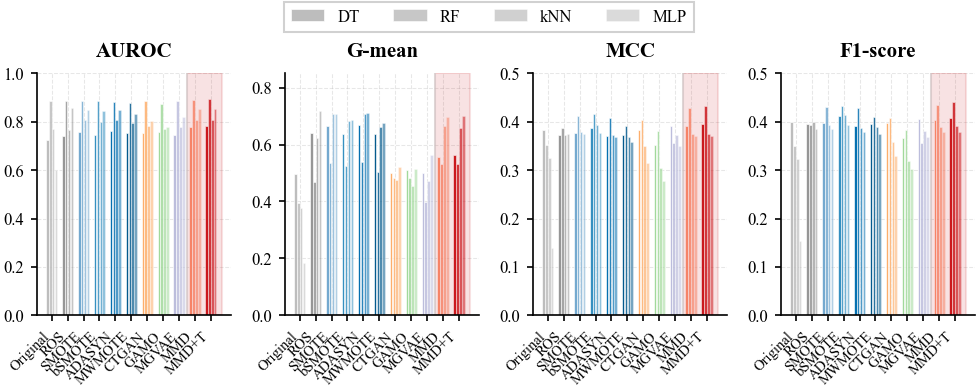

In [18]:
# ============================================================================
# Main Visualization: Classifier-Agnostic Performance
# ============================================================================
# Key message: MMD+T (MMD+T) consistently produces high-quality samples
# across ALL classifiers, demonstrating classifier-agnostic sample quality.

def create_classifier_agnostic_bar_chart(avg_df, classifiers, metrics, method_order, 
                                          method_colors, method_labels, classifier_labels,
                                          figsize=None, save_path=None):
    """
    Create a publication-quality grouped bar chart.
    
    Layout: 1 row x 4 columns (one per metric)
    Each subplot shows methods on x-axis, with bars for each classifier grouped together.
    This emphasizes: "For each metric, our method works well across all classifiers"
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH / 2.5)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    
    # Filter only methods that exist in data
    available_methods = [m for m in method_order if m in avg_df['Method'].unique()]
    n_methods = len(available_methods)
    n_classifiers = len(classifiers)
    
    # Bar width and positions
    bar_width = 0.18
    x = np.arange(n_methods)
    
    # Classifier colors (shades of each method's color or distinct)
    classifier_hatches = ['', '///', '...', 'xxx']  # Different patterns
    classifier_alphas = [1.0, 0.85, 0.7, 0.55]
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        for k, classifier in enumerate(classifiers):
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            plot_data = avg_df[mask].copy()
            
            # Ensure method order
            plot_data['Method'] = pd.Categorical(plot_data['Method'], 
                                                  categories=available_methods, 
                                                  ordered=True)
            plot_data = plot_data.sort_values('Method')
            
            # Get values in correct order
            values = plot_data['Mean'].values
            stds = plot_data['Std'].values
            
            # Position for this classifier's bars
            pos = x + (k - n_classifiers/2 + 0.5) * bar_width
            
            # Get colors
            colors = [method_colors.get(m, '#333333') for m in available_methods]
            
            # Create bars
            bars = ax.bar(pos, values, bar_width * 0.9, 
                         color=colors, 
                         alpha=classifier_alphas[k],
                         edgecolor='white',
                         linewidth=0.3,
                         label=classifier_labels.get(classifier, classifier) if j == 0 else '')
            
            # Error bars (only show for cleaner look, or comment out)
            # ax.errorbar(pos, values, yerr=stds, fmt='none', color='#333333', 
            #            capsize=1.5, capthick=0.4, linewidth=0.4, alpha=0.7)
        
        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels([method_labels.get(m, m) for m in available_methods], 
                          rotation=45, ha='right', fontsize=7)
        
        # Set y-axis limits (start from 0 to show all values including low MLP Original)
        if metric == 'AUROC':
            ax.set_ylim(0, 1.0)
        elif metric == 'G-mean':
            ax.set_ylim(0, 0.85)
        elif metric == 'MCC':
            ax.set_ylim(0, 0.50)
        else:  # F1-score
            ax.set_ylim(0, 0.50)
        
        ax.set_title(metric, fontsize=10, fontweight='bold', pad=8)
        
        # Add vertical line to separate "Ours"
        ax.axvline(x=n_methods - 2.5, color='#cccccc', linestyle='-', linewidth=0.8, alpha=0.7)
        
        # Highlight "Ours" region with subtle RED background
        ax.axvspan(n_methods - 2.5, n_methods - 0.3, alpha=0.12, color='#cb181d')
    
    # Add single legend for classifiers
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, 
               bbox_to_anchor=(0.5, 1.02), frameon=True, fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create the main visualization
fig = create_classifier_agnostic_bar_chart(
    avg_metrics, 
    CLASSIFIERS, 
    METRICS, 
    METHOD_ORDER, 
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_comparison_main.pdf'
)


Saved: ../../results/figures/classifier_comparison_per_classifier.pdf


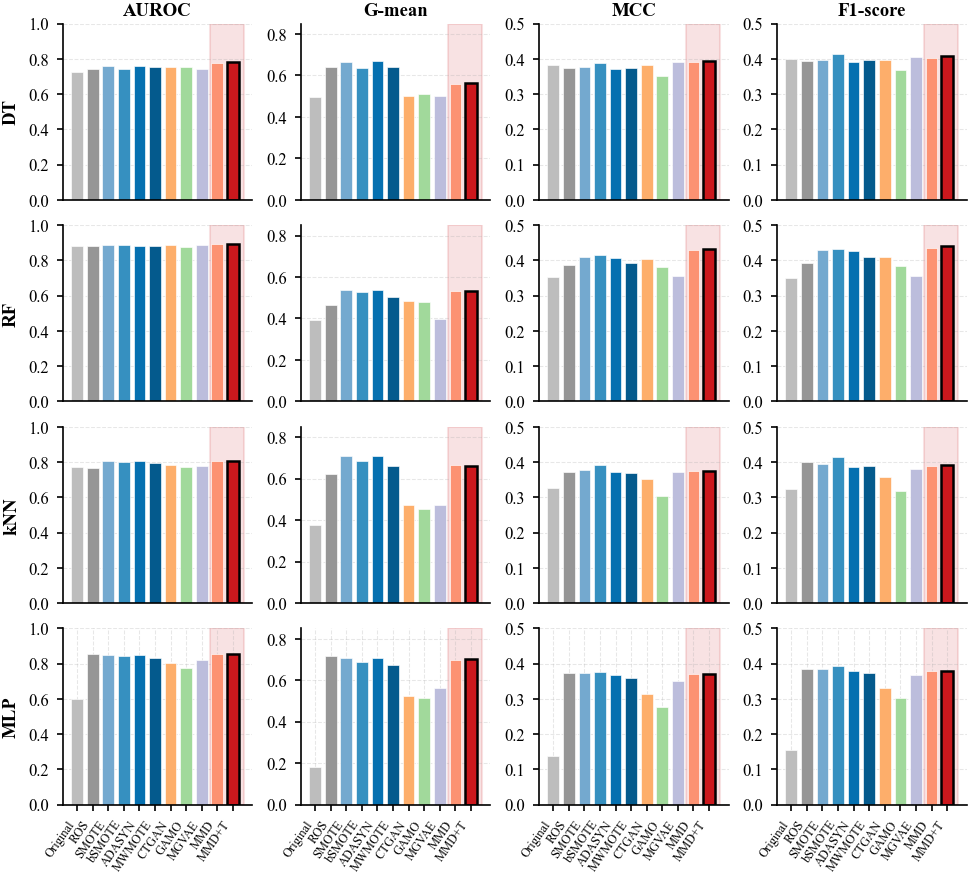

In [19]:
# ============================================================================
# Key Visualization: Per-Classifier Performance (Main Figure for Paper)
# ============================================================================
# This figure clearly shows that MMD+T (MMD+T) achieves consistent 
# performance across different classifiers.

def create_per_classifier_comparison(avg_df, classifiers, metrics, method_order, 
                                      method_colors, method_labels, classifier_labels,
                                      figsize=None, save_path=None):
    """
    Create a 4x4 grid (classifiers x metrics) showing method performance.
    Each cell shows bars for all methods, emphasizing consistency of "MMD+T".
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH * 0.9)
    
    fig, axes = plt.subplots(len(classifiers), len(metrics), figsize=figsize)
    
    available_methods = [m for m in method_order if m in avg_df['Method'].unique()]
    n_methods = len(available_methods)
    
    for i, classifier in enumerate(classifiers):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            plot_data = avg_df[mask].copy()
            
            plot_data['Method'] = pd.Categorical(plot_data['Method'], 
                                                  categories=available_methods, 
                                                  ordered=True)
            plot_data = plot_data.sort_values('Method')
            
            x = np.arange(len(plot_data))
            values = plot_data['Mean'].values
            colors = [method_colors.get(m, '#333333') for m in plot_data['Method']]
            
            # Create bars with emphasis on "MMD+T"
            bars = ax.bar(x, values, color=colors, edgecolor='white', linewidth=0.3, width=0.75)
            
            # Highlight "MMD+T" with edge
            for idx, m in enumerate(plot_data['Method']):
                if m == 'MMD+T':
                    bars[idx].set_edgecolor('#000000')
                    bars[idx].set_linewidth(1.2)
            
            # Y-axis limits (start from 0 to show all values including low MLP Original)
            if metric == 'AUROC':
                ax.set_ylim(0, 1.0)
            elif metric == 'G-mean':
                ax.set_ylim(0, 0.85)
            elif metric == 'MCC':
                ax.set_ylim(0, 0.50)
            else:  # F1-score
                ax.set_ylim(0, 0.50)
            
            # Labels
            if i == 0:
                ax.set_title(metric, fontsize=9, fontweight='bold', pad=4)
            if j == 0:
                ax.set_ylabel(classifier_labels.get(classifier, classifier), 
                             fontsize=9, fontweight='bold')
            
            # X-axis: only show labels on bottom row
            if i == len(classifiers) - 1:
                ax.set_xticks(x)
                ax.set_xticklabels([method_labels.get(m, m) for m in plot_data['Method']], 
                                  rotation=55, ha='right', fontsize=6)
            else:
                ax.set_xticks([])
            
            # Subtle RED background for "Ours" columns
            ax.axvspan(n_methods - 2.5, n_methods - 0.3, alpha=0.12, color='#cb181d', zorder=0)
            
            # Grid
            ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
            ax.set_axisbelow(True)
    
    plt.tight_layout(h_pad=0.5, w_pad=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create per-classifier comparison (main figure)
fig_per_clf = create_per_classifier_comparison(
    avg_metrics,
    CLASSIFIERS,
    METRICS,
    METHOD_ORDER,
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_comparison_per_classifier.pdf'
)


In [ ]:
# ============================================================================
# Line Plot Visualization: Classifier-Agnostic Robustness
# ============================================================================
# Key message: MMD/MMD+T maintain STABLE and HIGH performance across classifiers,
# while other methods show more variance (ups and downs).
# X-axis: Classifier, Y-axis: Metric value, Each line: Method

def create_classifier_robustness_lineplot(avg_df, classifiers, metrics, method_order, 
                                           method_colors, method_labels, classifier_labels,
                                           figsize=None, save_path=None):
    """
    Line plot showing method performance across classifiers.
    
    Design:
    - X-axis: Classifiers (RF, DT, kNN, MLP)
    - Y-axis: Metric value
    - Each line: One method
    - 1 row x 4 columns (one per metric)
    
    Key insight: Flat, high lines = robust, good performance (MMD/MMD+T)
                 Fluctuating lines = classifier-dependent (other methods)
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH / 2.2)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharey=False)
    
    available_methods = [m for m in method_order if m in avg_df['Method'].unique()]
    clf_order = ['RandomForest', 'DecisionTree', 'kNN', 'MLP']
    clf_labels = [classifier_labels.get(c, c) for c in clf_order]
    
    # Line styles for visual distinction
    # Traditional: solid, DL baselines: dashed, Ours: solid + thicker
    method_linestyles = {
        'Original': '-', 'ROS': '-', 'SMOTE': '-', 'bSMOTE': '-', 
        'ADASYN': '-', 'MWMOTE': '-',
        'CTGAN': '--', 'GAMO': '--', 'MGVAE': '--',
        'MMD': '-', 'MMD+T': '-'
    }
    
    method_linewidths = {m: 1.2 for m in available_methods}
    method_linewidths['MMD'] = 2.2
    method_linewidths['MMD+T'] = 2.8
    
    method_markers = {
        'Original': 'o', 'ROS': 's', 'SMOTE': '^', 'bSMOTE': 'v', 
        'ADASYN': 'D', 'MWMOTE': 'P',
        'CTGAN': 'X', 'GAMO': '*', 'MGVAE': 'p',
        'MMD': 'o', 'MMD+T': 's'
    }
    
    method_markersizes = {m: 5 for m in available_methods}
    method_markersizes['MMD'] = 7
    method_markersizes['MMD+T'] = 8
    
    # Z-order: Ours should be on top
    method_zorder = {m: 1 for m in available_methods}
    method_zorder['MMD'] = 10
    method_zorder['MMD+T'] = 11
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        for method in available_methods:
            # Get data for this method across classifiers
            values = []
            for clf in clf_order:
                mask = (avg_df['Method'] == method) & \
                       (avg_df['Classifier'] == clf) & \
                       (avg_df['Metric'] == metric)
                val = avg_df.loc[mask, 'Mean'].values
                values.append(val[0] if len(val) > 0 else np.nan)
            
            # Determine alpha (muted for baselines, bold for Ours)
            alpha = 1.0 if method in ['MMD', 'MMD+T'] else 0.6
            
            ax.plot(range(len(clf_order)), values, 
                   color=method_colors.get(method, '#333333'),
                   linestyle=method_linestyles.get(method, '-'),
                   linewidth=method_linewidths.get(method, 1.2),
                   marker=method_markers.get(method, 'o'),
                   markersize=method_markersizes.get(method, 5),
                   markeredgecolor='white',
                   markeredgewidth=0.5,
                   alpha=alpha,
                   zorder=method_zorder.get(method, 1),
                   label=method_labels.get(method, method))
        
        # Formatting
        ax.set_xticks(range(len(clf_order)))
        ax.set_xticklabels(clf_labels, fontsize=8)
        ax.set_xlabel('Classifier', fontsize=9)
        
        if j == 0:
            ax.set_ylabel('Performance', fontsize=9)
        
        # Y-axis limits
        if metric == 'AUROC':
            ax.set_ylim(0.5, 0.95)
        elif metric == 'G-mean':
            ax.set_ylim(0.1, 0.75)
        elif metric == 'MCC':
            ax.set_ylim(0.0, 0.45)
        else:  # F1-score
            ax.set_ylim(0.1, 0.45)
        
        ax.set_title(metric, fontsize=10, fontweight='bold', pad=8)
        ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
        ax.set_axisbelow(True)
    
    # Legend - put outside the plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.15, 0.5), frameon=True, fontsize=7,
               title='Method', title_fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create the line plot
fig_line = create_classifier_robustness_lineplot(
    avg_metrics,
    CLASSIFIERS,
    METRICS,
    METHOD_ORDER,
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_robustness_lineplot.pdf'
)


In [ ]:
# ============================================================================
# Alternative: Simplified Line Plot (Focus on Key Methods)
# ============================================================================
# Too many lines can be cluttered. This version focuses on:
# - Original (baseline)
# - Best traditional (SMOTE)
# - Best DL (GAMO)
# - MMD and MMD+T (Ours)

def create_focused_lineplot(avg_df, classifiers, metrics, method_colors, 
                            method_labels, classifier_labels,
                            figsize=None, save_path=None):
    """
    Simplified line plot focusing on key methods for cleaner visualization.
    """
    # Key methods to highlight
    focus_methods = ['Original', 'SMOTE', 'GAMO', 'MMD', 'MMD+T']
    
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH / 2.5)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharey=False)
    
    clf_order = ['RandomForest', 'DecisionTree', 'kNN', 'MLP']
    clf_labels = [classifier_labels.get(c, c) for c in clf_order]
    
    # Custom styling for focus methods
    method_styles = {
        'Original': {'ls': ':', 'lw': 1.5, 'marker': 'o', 'ms': 5, 'alpha': 0.5},
        'SMOTE': {'ls': '-', 'lw': 1.5, 'marker': '^', 'ms': 6, 'alpha': 0.7},
        'GAMO': {'ls': '--', 'lw': 1.5, 'marker': '*', 'ms': 8, 'alpha': 0.7},
        'MMD': {'ls': '-', 'lw': 2.2, 'marker': 'o', 'ms': 7, 'alpha': 1.0},
        'MMD+T': {'ls': '-', 'lw': 2.8, 'marker': 's', 'ms': 8, 'alpha': 1.0},
    }
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        for method in focus_methods:
            style = method_styles[method]
            
            values = []
            for clf in clf_order:
                mask = (avg_df['Method'] == method) & \
                       (avg_df['Classifier'] == clf) & \
                       (avg_df['Metric'] == metric)
                val = avg_df.loc[mask, 'Mean'].values
                values.append(val[0] if len(val) > 0 else np.nan)
            
            zorder = 10 if method in ['MMD', 'MMD+T'] else 1
            
            ax.plot(range(len(clf_order)), values,
                   color=method_colors.get(method, '#333333'),
                   linestyle=style['ls'],
                   linewidth=style['lw'],
                   marker=style['marker'],
                   markersize=style['ms'],
                   markeredgecolor='white',
                   markeredgewidth=0.8,
                   alpha=style['alpha'],
                   zorder=zorder,
                   label=method_labels.get(method, method))
        
        ax.set_xticks(range(len(clf_order)))
        ax.set_xticklabels(clf_labels, fontsize=9)
        ax.set_xlabel('Classifier', fontsize=9)
        
        if j == 0:
            ax.set_ylabel('Performance', fontsize=9)
        
        # Y-axis limits
        if metric == 'AUROC':
            ax.set_ylim(0.55, 0.9)
        elif metric == 'G-mean':
            ax.set_ylim(0.2, 0.7)
        elif metric == 'MCC':
            ax.set_ylim(0.05, 0.4)
        else:  # F1-score
            ax.set_ylim(0.15, 0.4)
        
        ax.set_title(metric, fontsize=10, fontweight='bold', pad=8)
        ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
        ax.set_axisbelow(True)
    
    # Legend
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5,
               bbox_to_anchor=(0.5, 1.08), frameon=True, fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create focused line plot
fig_focused = create_focused_lineplot(
    avg_metrics,
    CLASSIFIERS,
    METRICS,
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_robustness_focused.pdf'
)


In [ ]:
# ============================================================================
# Robustness Quantification: Classifier Variance Analysis
# ============================================================================
# Compute standard deviation across classifiers for each method.
# Lower std = more robust (classifier-agnostic)
# This directly supports the claim: "MMD/MMD+T are robust across classifiers"

def compute_classifier_variance(avg_df, methods, classifiers, metrics):
    """
    Compute performance variance across classifiers for each method.
    Returns DataFrame with mean performance and std across classifiers.
    """
    results = []
    
    for method in methods:
        for metric in metrics:
            values = []
            for clf in classifiers:
                mask = (avg_df['Method'] == method) & \
                       (avg_df['Classifier'] == clf) & \
                       (avg_df['Metric'] == metric)
                val = avg_df.loc[mask, 'Mean'].values
                if len(val) > 0:
                    values.append(val[0])
            
            if values:
                results.append({
                    'Method': method,
                    'Metric': metric,
                    'Mean': np.mean(values),
                    'Std': np.std(values),  # Classifier variance
                    'Min': np.min(values),
                    'Max': np.max(values),
                    'Range': np.max(values) - np.min(values)
                })
    
    return pd.DataFrame(results)

# Compute robustness metrics
robustness_df = compute_classifier_variance(avg_metrics, METHOD_ORDER, CLASSIFIERS, METRICS)
print("Robustness Analysis (Std across classifiers - lower is better):\n")
for metric in METRICS:
    print(f"\n{metric}:")
    subset = robustness_df[robustness_df['Metric'] == metric].sort_values('Std')
    for _, row in subset.iterrows():
        print(f"  {row['Method']:12s}: Mean={row['Mean']:.4f}, Std={row['Std']:.4f} (range: {row['Range']:.4f})")


In [ ]:
# ============================================================================
# Scatter Plot: Mean Performance vs Classifier Variance (Robustness)
# ============================================================================
# X-axis: Mean performance (higher = better)
# Y-axis: Std across classifiers (lower = more robust)
# Ideal: Top-right quadrant (high performance, low variance)
# → Methods in bottom-right are BOTH high-performing AND robust

def create_mean_vs_robustness_scatter(robustness_df, metrics, method_colors, 
                                       method_labels, figsize=None, save_path=None):
    """
    Scatter plot showing trade-off between mean performance and robustness.
    Bottom-right = best (high mean, low std)
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH * 0.8)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        subset = robustness_df[robustness_df['Metric'] == metric]
        
        for _, row in subset.iterrows():
            method = row['Method']
            is_ours = method in ['MMD', 'MMD+T']
            
            # Marker size based on importance
            size = 120 if is_ours else 60
            marker = 's' if method == 'MMD+T' else ('o' if method == 'MMD' else 'o')
            alpha = 1.0 if is_ours else 0.6
            edgecolor = 'black' if is_ours else 'white'
            linewidth = 1.5 if is_ours else 0.5
            zorder = 10 if is_ours else 1
            
            ax.scatter(row['Mean'], row['Std'],
                      c=method_colors.get(method, '#333333'),
                      s=size, marker=marker, alpha=alpha,
                      edgecolors=edgecolor, linewidths=linewidth,
                      zorder=zorder)
            
            # Add labels
            offset_x = 0.008 if not is_ours else 0.012
            offset_y = 0.002
            fontsize = 8 if is_ours else 6
            fontweight = 'bold' if is_ours else 'normal'
            
            ax.annotate(method_labels.get(method, method), 
                       (row['Mean'] + offset_x, row['Std'] + offset_y),
                       fontsize=fontsize, fontweight=fontweight,
                       alpha=0.9 if is_ours else 0.7)
        
        ax.set_xlabel('Mean Performance ↑', fontsize=9)
        ax.set_ylabel('Std (Variance) ↓', fontsize=9)
        ax.set_title(metric, fontsize=10, fontweight='bold', pad=8)
        
        # Add "ideal" annotation arrow pointing to bottom-right
        ax.annotate('', xy=(ax.get_xlim()[1]*0.95, ax.get_ylim()[0]*1.1),
                   xytext=(ax.get_xlim()[0]*1.05, ax.get_ylim()[1]*0.9),
                   arrowprops=dict(arrowstyle='->', color='green', alpha=0.3, lw=1.5))
        
        ax.grid(True, alpha=0.3, linewidth=0.5)
    
    # Add common subtitle
    fig.suptitle('Performance vs Robustness (bottom-right = best)', 
                fontsize=11, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create scatter plot
fig_scatter = create_mean_vs_robustness_scatter(
    robustness_df,
    METRICS,
    METHOD_COLORS,
    METHOD_LABELS,
    save_path='../../results/figures/mean_vs_robustness_scatter.pdf'
)


In [ ]:
# ============================================================================
# Summary Table: Robustness Ranking
# ============================================================================
# Rank methods by: 1) Mean performance, 2) Robustness (1/Std)
# Combined score = Mean * (1 - normalized_std) or similar

def create_robustness_summary_table(robustness_df, metrics, method_order):
    """
    Create summary table with rankings for each metric.
    """
    summary_data = []
    
    for method in method_order:
        row = {'Method': method}
        total_mean_rank = 0
        total_std_rank = 0
        
        for metric in metrics:
            subset = robustness_df[robustness_df['Metric'] == metric].copy()
            
            # Rank by mean (higher is better, so ascending=False)
            subset['Mean_Rank'] = subset['Mean'].rank(ascending=False)
            # Rank by std (lower is better, so ascending=True)
            subset['Std_Rank'] = subset['Std'].rank(ascending=True)
            
            method_row = subset[subset['Method'] == method]
            if not method_row.empty:
                row[f'{metric}_Mean'] = method_row['Mean'].values[0]
                row[f'{metric}_Std'] = method_row['Std'].values[0]
                row[f'{metric}_MeanRank'] = int(method_row['Mean_Rank'].values[0])
                row[f'{metric}_StdRank'] = int(method_row['Std_Rank'].values[0])
                total_mean_rank += method_row['Mean_Rank'].values[0]
                total_std_rank += method_row['Std_Rank'].values[0]
        
        row['Avg_Mean_Rank'] = total_mean_rank / len(metrics)
        row['Avg_Std_Rank'] = total_std_rank / len(metrics)
        row['Combined_Rank'] = (row['Avg_Mean_Rank'] + row['Avg_Std_Rank']) / 2
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values('Combined_Rank')

# Create and display summary
summary_df = create_robustness_summary_table(robustness_df, METRICS, METHOD_ORDER)

print("=" * 80)
print("ROBUSTNESS SUMMARY TABLE")
print("=" * 80)
print("\nRankings (1 = best):")
print("-" * 80)

# Display simplified version
display_cols = ['Method', 'Avg_Mean_Rank', 'Avg_Std_Rank', 'Combined_Rank']
print(summary_df[display_cols].to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDING:")
print("=" * 80)
print("\nMethods with BOTH high mean performance AND low classifier variance (robust):")
top_methods = summary_df.head(3)['Method'].tolist()
print(f"  Top 3: {', '.join(top_methods)}")

# Highlight MMD and MMD+T
mmd_rank = summary_df[summary_df['Method'] == 'MMD']['Combined_Rank'].values[0]
mmdt_rank = summary_df[summary_df['Method'] == 'MMD+T']['Combined_Rank'].values[0]
print(f"\n  MMD   Combined Rank: {mmd_rank:.1f}")
print(f"  MMD+T Combined Rank: {mmdt_rank:.1f}")


## Summary: Visualization Strategy for Robustness Claim

### Key Claim to Support
**"MMD, MMD+T가 classifier 상관없이 전체적으로 모든 metrics에서 robust하게 준수한 성능을 보인다."**

### Visualization Options Created

| Plot Type | Purpose | When to Use |
|-----------|---------|-------------|
| **Line Plot (Full)** | Shows all 11 methods across classifiers | Comprehensive view, may be cluttered |
| **Line Plot (Focused)** | Shows key methods only (Original, SMOTE, GAMO, MMD, MMD+T) | **Recommended for main paper** - cleaner, key comparison |
| **Scatter Plot (Mean vs Std)** | Directly shows performance vs robustness trade-off | **Strong visual argument** - MMD/MMD+T in bottom-right = best |
| **Bar Plot (4x4 grid)** | Traditional comparison per classifier/metric | Good for detailed appendix |

### Recommended Figure for Paper

**Option 1: Focused Line Plot** (`classifier_robustness_focused.pdf`)
- Clean, readable
- Shows MMD/MMD+T lines are **flat and high** across all classifiers
- Other methods fluctuate more

**Option 2: Mean vs Std Scatter** (`mean_vs_robustness_scatter.pdf`)
- Directly visualizes the robustness claim
- X-axis: Mean performance (higher = better)
- Y-axis: Std across classifiers (lower = more robust)
- **Bottom-right quadrant = best** (high performance + low variance)
- MMD/MMD+T should appear in this ideal region

### Key Metrics to Highlight
1. **Classifier Variance (Std)**: Lower = more robust to classifier choice
2. **Mean Performance**: Higher = better overall quality
3. **Combined Ranking**: Balances both aspects
